In [3]:
# Import Library
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, GlobalMaxPool1D, Bidirectional, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D
from keras.callbacks import EarlyStopping, LearningRateScheduler

# **EDA(exploratory data analysis)**

In [ ]:
# Load data dari file JSON
file_path = "/content/FAQ_Chatbot_Updated.json"
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Menampilkan jumlah intents untuk memvalidasi data telah berhasil dimuat
print(f"Jumlah intents yang dimuat: {len(data['intents'])}")

# Contoh beberapa intents
for intent in data['intents'][:3]:  # Menampilkan 3 intents pertama
    print(f"Tag: {intent['tag']}")
    print(f"Patterns: {intent['patterns'][:2]}")  # 2 contoh patterns
    print(f"Responses: {intent['responses'][:1]}")  # 1 contoh response
    print("-" * 50)


Jumlah intents yang dimuat: 25
Tag: barang_bawaan_asrama
Patterns: ['Barang pribadi apa saja yang perlu dibawa ke asrama?', 'Apa saja barang pribadi yang harus dibawa saat check-in ke asrama?']
Responses: ['Mahasiswa dibebaskan untuk membawa barang pribadi ke asrama, namun tidak diperkenankan membawa alat elektronik selain Laptop dan Handphone. Selain itu juga tidak diperkenankan membawa senjata tajam, kompor dan lainya. Mahasiswa asrama juga diharapkan membawa alat kebersihan seperti sapu, pel dan lainya karena di asrama tidak disediakan.']
--------------------------------------------------
Tag: alur_checkin_asrama
Patterns: ['Apa itu prosedur check-in Asrama ITERA?', 'Bagaimana alur check-in untuk penghuni Asrama ITERA?']
Responses: ['Selamat datang di Asrama Mahasiswa ITERA! Prosedur check-in adalah langkah-langkah yang harus diikuti calon penghuni asrama setelah dinyatakan lolos seleksi penerimaan. Prosedur ini bertujuan untuk memastikan kenyamanan dan keamanan seluruh penghuni.\n\

In [ ]:
import json
import pandas as pd

# Ekstrak maksud, pola, dan respons ke dalam DataFrame terstruktur
intents_data = []
for intent in data["intents"]:
    tag = intent["tag"]
    for pattern in intent.get("patterns", []):
        for response in intent.get("responses", []):
            intents_data.append({
                "tag": tag,
                "pattern": pattern,
                "response": response
            })

# Membuat DataFrame
df_intents = pd.DataFrame(intents_data)

#output df_intents
df_intents

,tag,pattern,response
0,barang_bawaan_asrama,Barang pribadi apa saja yang perlu dibawa ke a...,Mahasiswa dibebaskan untuk membawa barang prib...
1,barang_bawaan_asrama,Barang pribadi apa saja yang perlu dibawa ke a...,Mahasiswa diizinkan membawa barang pribadi ke ...
2,barang_bawaan_asrama,Barang pribadi apa saja yang perlu dibawa ke a...,Mahasiswa bebas membawa barang pribadi ke asra...
3,barang_bawaan_asrama,Barang pribadi apa saja yang perlu dibawa ke a...,Mahasiswa diperbolehkan membawa barang pribadi...
4,barang_bawaan_asrama,Barang pribadi apa saja yang perlu dibawa ke a...,Barang pribadi diperbolehkan untuk dibawa ke a...
...,...,...,...
1531,biaya_asrama_itera,Berapa tarif kamar asrama ITERA?,"Biaya Asrama:\n- Rp200.000 per bulan, dibayark..."
1532,biaya_asrama_itera,Apakah biaya asrama ITERA termasuk listrik dan...,"Biaya Asrama:\n- Rp200.000 per bulan, dibayark..."
1533,biaya_asrama_itera,biaya asrama ITERA,"Biaya Asrama:\n- Rp200.000 per bulan, dibayark..."
1534,biaya_asrama_itera,uang asrama ITERA,"Biaya Asrama:\n- Rp200.000 per bulan, dibayark..."


In [ ]:
# Ekstrak maksud, pola, dan respons ke dalam DataFrame terstruktur
intents_data = []
for intent in data["intents"]:
    tag = intent["tag"]
    patterns = intent.get("patterns", [])
    responses = intent.get("responses", [])
    intents_data.append({
        "tag": tag,
        "num_patterns": len(patterns),
        "num_responses": len(responses),
        "patterns": patterns,
        "responses": responses
    })

# membuat DataFrame unutuk analisis
df_intents = pd.DataFrame(intents_data)

# eksplorasi statisitk
summary_stats = {
    "total_intents": len(df_intents),
    "total_patterns": df_intents["num_patterns"].sum(),
    "total_responses": df_intents["num_responses"].sum(),
    "average_patterns_per_intent": df_intents["num_patterns"].mean(),
    "average_responses_per_intent": df_intents["num_responses"].mean(),
    "max_patterns_in_intent": df_intents["num_patterns"].max(),
    "max_responses_in_intent": df_intents["num_responses"].max()
}

# Distribution of patterns and responses per tag
patterns_distribution = df_intents[["tag", "num_patterns"]].sort_values(by="num_patterns", ascending=False)
responses_distribution = df_intents[["tag", "num_responses"]].sort_values(by="num_responses", ascending=False)

# Longest and shortest responses
all_responses = [(tag, response) for tag in df_intents["tag"] for response in df_intents[df_intents["tag"] == tag]["responses"].iloc[0]]
responses_length = [(tag, response, len(response)) for tag, response in all_responses]
responses_df = pd.DataFrame(responses_length, columns=["tag", "response", "length"])
longest_responses = responses_df.nlargest(5, "length")
shortest_responses = responses_df.nsmallest(5, "length")


---
## 1. Statistik Umum
- **Total intents (kategori/tag)**: 25
- **Total pola (patterns)**: 417
- **Total respons**: 98
- **Rata-rata pola per intent**: ~16.68
- **Rata-rata respons per intent**: ~3.92
- **Jumlah pola terbanyak dalam satu intent**: 40 (tag: `larangan_penghuni_asrama`)
- **Jumlah respons terbanyak dalam satu intent**: 14 (tag: `pembayaran_cicilan`)


In [ ]:
# OUTPUT
summary_stats

{'total_intents': 25,
 'total_patterns': 417,
 'total_responses': 98,
 'average_patterns_per_intent': 16.68,
 'average_responses_per_intent': 3.92,
 'max_patterns_in_intent': 40,
 'max_responses_in_intent': 14}

In [ ]:
# dstribusi data pattern
patterns_distribution.sort_index(inplace=True)
patterns_distribution

,tag,num_patterns
0,barang_bawaan_asrama,11
1,alur_checkin_asrama,21
2,prosedur_Pembayaran_Asrama,20
3,verifikasi_berkas_checkin,22
4,dokumen_asrama_itera,20
5,fungsi_asrama,8
6,kewajiban_penghuni_asrama,6
7,hak_penghuni_asrama,6
8,sanksi_pelanggaran_asrama,6
9,larangan_penghuni_asrama,40


In [ ]:
# dstribusi data response
responses_distribution.sort_index(inplace=True)
responses_distribution

,tag,num_responses
0,barang_bawaan_asrama,11
1,alur_checkin_asrama,1
2,prosedur_Pembayaran_Asrama,1
3,verifikasi_berkas_checkin,1
4,dokumen_asrama_itera,1
5,fungsi_asrama,2
6,kewajiban_penghuni_asrama,1
7,hak_penghuni_asrama,1
8,sanksi_pelanggaran_asrama,1
9,larangan_penghuni_asrama,1


In [ ]:
longest_responses

,tag,response,length
94,berkas_checkin_asrama,Dokumen yang perlu dibawa saat check-in Asrama...,717
14,dokumen_asrama_itera,Surat rekomendasi pendaftaran Kakak Asrama: [U...,662
11,alur_checkin_asrama,Selamat datang di Asrama Mahasiswa ITERA! Pros...,633
20,larangan_penghuni_asrama,Penghuni asrama ITERA dilarang untuk:\n\n1. Me...,598
13,verifikasi_berkas_checkin,Proses Check-In Fisik:\n\n1. Datang langsung k...,550


In [ ]:
shortest_responses

,tag,response,length
49,ucapan_perpisahan,"Terima kasih telah berkunjung, Sampai jumpa ke...",55
85,ucapan_sapaan,Hi kenalkan saya chatbot FAQ yang siap menjawa...,63
86,ucapan_sapaan,Halo kenalkan saya chatbot FAQ yang siap menja...,65
87,ucapan_sapaan,Hello kenalkan saya chatbot FAQ yang siap menj...,66
88,ucapan_sapaan,"Hi ITERA Friends, kenalkan saya chatbot FAQ ya...",78


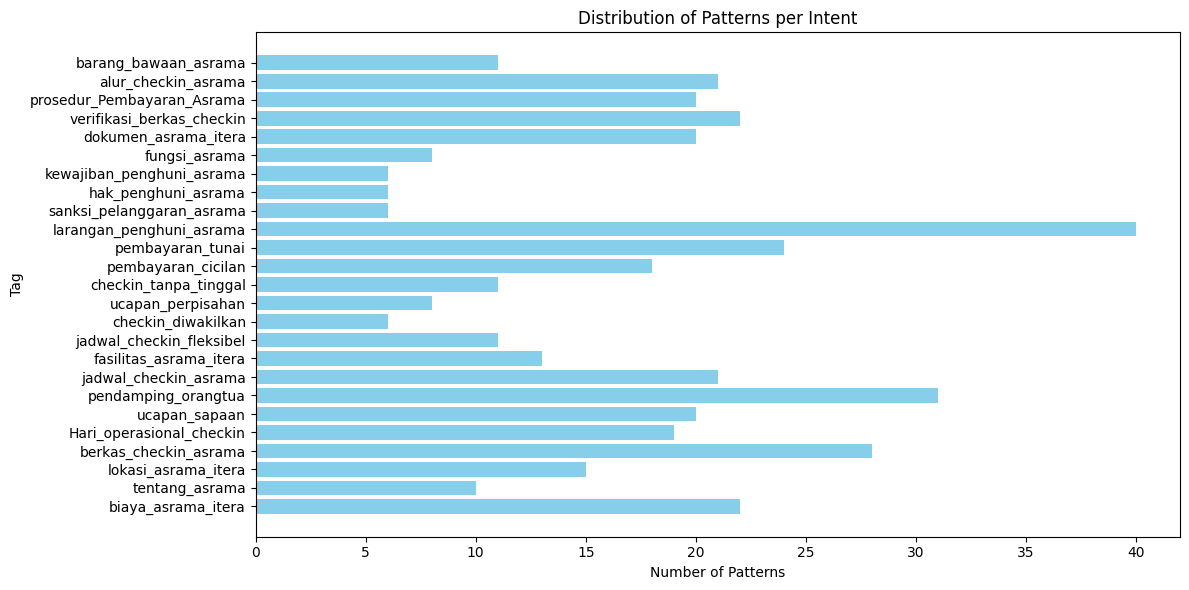

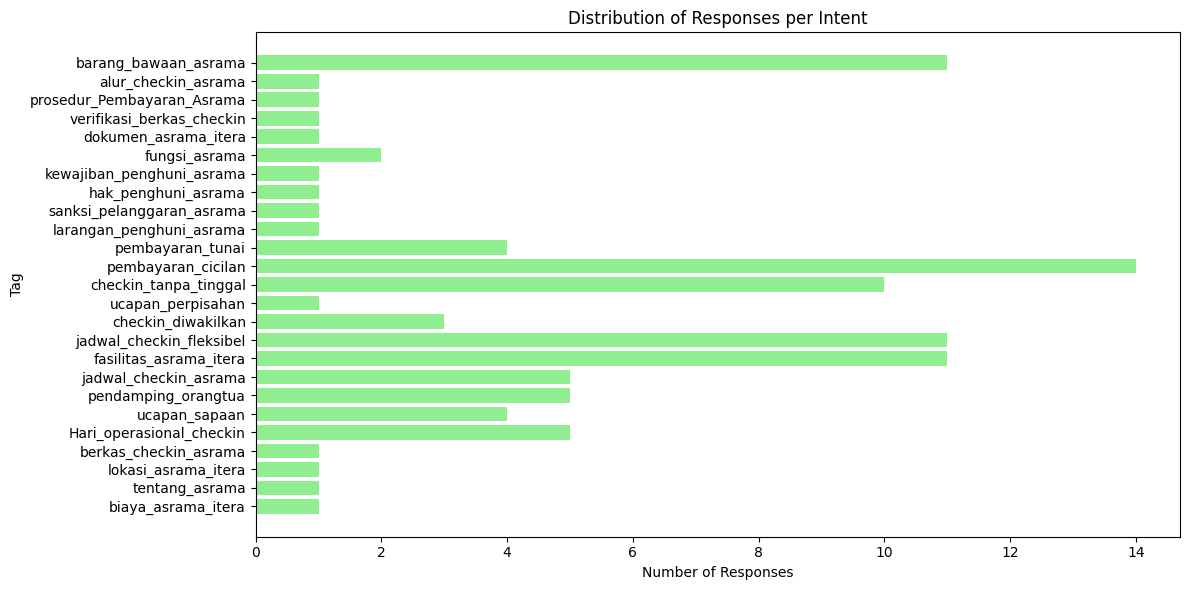

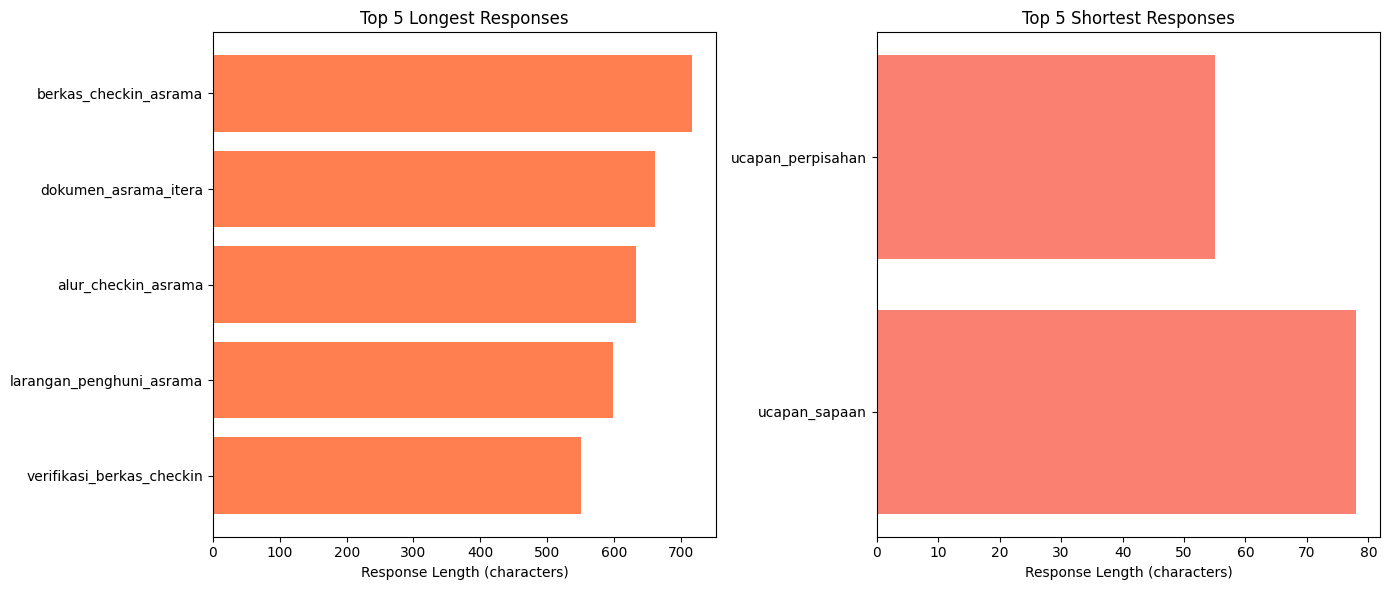

In [ ]:
import matplotlib.pyplot as plt

# Plot 1: Distribusi patterns per intent
plt.figure(figsize=(12, 6))
plt.barh(patterns_distribution["tag"], patterns_distribution["num_patterns"], color="skyblue")
plt.xlabel("Number of Patterns")
plt.ylabel("Tag")
plt.title("Distribution of Patterns per Intent")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot 2: Distribusi responses per intent
plt.figure(figsize=(12, 6))
plt.barh(responses_distribution["tag"], responses_distribution["num_responses"], color="lightgreen")
plt.xlabel("Number of Responses")
plt.ylabel("Tag")
plt.title("Distribution of Responses per Intent")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot 3: panjang responses (top 5 longest and shortest)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Longest responses
axes[0].barh(longest_responses["tag"], longest_responses["length"], color="coral")
axes[0].set_title("Top 5 Longest Responses")
axes[0].set_xlabel("Response Length (characters)")
axes[0].invert_yaxis()

# Shortest responses
axes[1].barh(shortest_responses["tag"], shortest_responses["length"], color="salmon")
axes[1].set_title("Top 5 Shortest Responses")
axes[1].set_xlabel("Response Length (characters)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
df = pd.DataFrame(intents_data)
df

,tag,num_patterns,num_responses,patterns,responses
0,barang_bawaan_asrama,11,11,[Barang pribadi apa saja yang perlu dibawa ke ...,[Mahasiswa dibebaskan untuk membawa barang pri...
1,alur_checkin_asrama,21,1,"[Apa itu prosedur check-in Asrama ITERA?, Baga...",[Selamat datang di Asrama Mahasiswa ITERA! Pro...
2,prosedur_Pembayaran_Asrama,20,1,"[Bagaimana prosedur pembayaran asrama?, Cara m...",[Prosedur Pembayaran:\n\n1. Setelah mengisi fo...
3,verifikasi_berkas_checkin,22,1,[Bagaimana proses verifikasi berkas fisik untu...,[Proses Check-In Fisik:\n\n1. Datang langsung ...
4,dokumen_asrama_itera,20,1,"[dokumen asrama, unduh dokumen asrama, Surat r...",[Surat rekomendasi pendaftaran Kakak Asrama: [...
5,fungsi_asrama,8,2,"[Apa fungsi asrama ITERA?, Mengapa asrama ITER...",[Asrama ITERA berfungsi sebagai sarana pendidi...
6,kewajiban_penghuni_asrama,6,1,"[Apa kewajiban penghuni asrama ITERA?, Apa yan...",[Penghuni asrama ITERA memiliki kewajiban untu...
7,hak_penghuni_asrama,6,1,"[Apa hak penghuni asrama ITERA?, Apa saja hak ...",[Penghuni asrama ITERA memiliki hak untuk:\n\n...
8,sanksi_pelanggaran_asrama,6,1,[Apa sanksi jika melanggar peraturan asrama IT...,[Penghuni yang melanggar peraturan asrama ITER...
9,larangan_penghuni_asrama,40,1,"[Apa saja yang dilarang di asrama ITERA?, Lara...",[Penghuni asrama ITERA dilarang untuk:\n\n1. M...


In [ ]:
import pandas as pd
from collections import Counter
import re

# Fungsi untuk menghitung frekuensi kata
def calculate_word_frequency(patterns):
    # Gabungkan semua teks dalam patterns menjadi satu string
    all_text = ' '.join(patterns)

    # Hapus tanda baca dan ubah teks menjadi huruf kecil
    all_text = re.sub(r'[^\w\s]', '', all_text).lower()

    # Hitung frekuensi kata
    word_counts = Counter(all_text.split())

    # Konversi hasil ke DataFrame
    word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

    return word_freq_df

# Ekstrak semua patterns
patterns = []
for intent in data["intents"]:
    patterns.extend(intent['patterns'])

# Hitung frekuensi kata
word_frequency_df = calculate_word_frequency(patterns)

# Tampilkan hasil
print(word_frequency_df.head(50))


              word  frequency
8           asrama        321
25           itera        214
2              apa        131
11         checkin        112
15              di        102
129         apakah         82
4             yang         81
21           untuk         65
13       mahasiswa         62
3             saja         47
132          kamar         46
51           biaya         40
49      pembayaran         34
10            saat         34
87            bisa         32
36        penghuni         32
34       bagaimana         31
62         dokumen         29
127          boleh         25
42       dilakukan         25
14         tinggal         25
18           masuk         25
7               ke         24
9            harus         24
287          orang         23
91             ada         23
50        membayar         22
354            tua         22
142  diperbolehkan         21
295         jadwal         19
133       bolehkah         19
335          kapan         18
117       

# Data Preprocessing

In [4]:
with open('/content/FAQ_Chatbot_Updated.json') as content:
  data = json.load(content)

In [5]:
# Package sentence tokenizer
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [6]:
# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])


In [ ]:
import pandas as pd

# Convert the responses dictionary into a Pandas DataFrame
responses_df = pd.DataFrame(list(responses.items()), columns=['tag', 'responses'])

# Save the DataFrame to a CSV file
responses_df.to_csv('responses.csv', index=False)

In [7]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(inputs, tags,test_size=0.2, random_state=20)

# Konversi data ke dalam dataframe
train_data = pd.DataFrame({"patterns": X_train, "tags": y_train})
test_data = pd.DataFrame({"patterns": X_test, "tags": y_test})

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  333 non-null    object
 1   tags      333 non-null    object
dtypes: object(2)
memory usage: 5.3+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  84 non-null     object
 1   tags      84 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [ ]:
train_data.describe()

,patterns,tags
count,333,333
unique,332,25
top,Dokumen apa saja yang harus dibawa saat check-...,larangan_penghuni_asrama
freq,2,35


In [ ]:
test_data.describe()

,patterns,tags
count,84,84
unique,84,23
top,Hey,pendamping_orangtua
freq,1,8


In [ ]:
train_data.head()

,patterns,tags
0,Syarat dokumen apa yang harus diserahkan saat ...,berkas_checkin_asrama
1,Jelaskan tentang asrama ITERA!,tentang_asrama
2,Dimana saya bisa unduh dokumen asrama ITERA?,dokumen_asrama_itera
3,Bagaimana alur pembayaran asrama ITERA?,prosedur_Pembayaran_Asrama
4,Asrama ITERA itu seperti apa?,tentang_asrama


In [ ]:
test_data.head()

,patterns,tags
0,Hey,ucapan_sapaan
1,Apakah ada pilihan untuk membayar uang asrama ...,pembayaran_tunai
2,Proses check-in asrama ITERA seperti apa?,alur_checkin_asrama
3,Larangan untuk penghuni asrama ITERA apa saja?,larangan_penghuni_asrama
4,Bisakah tamu masuk ke kamar penghuni asrama IT...,larangan_penghuni_asrama


In [8]:
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

In [9]:
# Inisialisasi Lemmatizer
lemmatizer = WordNetLemmatizer()

# Fungsi untuk melakukan lemmatization pada kata-kata dalam kalimat
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)  # Tokenisasi kata-kata dalam kalimat
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    lemmatized_text = ' '.join(lemmatized_tokens)  # Menggabungkan kembali kata-kata menjadi kalimat
    return lemmatized_text

# Contoh penggunaan fungsi lemmatize_text pada dataset
train_data['patterns'] = train_data['patterns'].apply(lemmatize_text)
test_data['patterns'] = test_data['patterns'].apply(lemmatize_text)

In [ ]:
train_data['patterns']

,patterns
0,syarat dokumen apa yang harus diserahkan saat ...
1,jelaskan tentang asrama itera
2,dimana saya bisa unduh dokumen asrama itera
3,bagaimana alur pembayaran asrama itera
4,asrama itera itu seperti apa
...,...
328,see you
329,berapa tarif kamar asrama itera
330,apakah diperkenankan checkin asrama itera mela...
331,jadwal checkin asrama


In [ ]:
test_data['patterns']

,patterns
0,hey
1,apakah ada pilihan untuk membayar uang asrama ...
2,prose checkin asrama itera seperti apa
3,larangan untuk penghuni asrama itera apa saja
4,bisakah tamu masuk ke kamar penghuni asrama itera
...,...
79,apa saja fasilitas asrama
80,selamat sore
81,hari apa saja bisa checkin
82,apakah pembayaran biaya asrama bisa dilakukan ...


# Feature Engineering

In [10]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_data['patterns'])

x_train = tokenizer.texts_to_sequences(train_data['patterns'])
x_test = tokenizer.texts_to_sequences(test_data['patterns'])

In [ ]:
x_train

[[112, 17, 3, 7, 20, 137, 16, 21, 5, 1, 2],
 [200, 50, 1, 2],
 [89, 34, 18, 76, 17, 1, 2],
 [14, 66, 15, 1, 2],
 [1, 2, 90, 91, 3],
 [14, 51, 4, 9, 58, 5, 1, 2],
 [3, 138, 1, 2],
 [3, 113, 13, 1, 2],
 [3, 7, 201, 13, 1, 2],
 [6, 19, 59, 202, 7, 203, 204, 13, 205],
 [6, 1, 2, 206],
 [35, 3, 7, 52, 92, 16, 207, 26, 1, 2],
 [114],
 [6, 27, 208, 8, 23, 1, 67, 209, 43, 37, 210, 12],
 [76, 93, 139, 21, 5, 1, 2],
 [60, 4, 1, 2],
 [68, 77, 3, 10, 7, 52, 38, 24, 1],
 [66, 4, 1, 2, 3, 10],
 [12, 21, 5, 1, 2, 211, 36, 40],
 [14, 61, 15, 8, 1, 2],
 [212],
 [89, 213, 1, 2],
 [214, 1, 2, 27],
 [6, 94, 62, 9, 8, 78, 44, 11, 115, 69, 215],
 [3, 35, 7, 140, 16, 26, 1, 2],
 [14, 32, 27, 7, 116, 63, 1, 2],
 [6, 29, 30, 94, 95, 9, 16, 216, 11],
 [3, 117, 118, 8, 4, 1, 2],
 [31, 9, 217, 44, 11, 70, 96, 97, 11],
 [4, 5, 64, 141, 218, 45],
 [3, 10, 79, 9, 5, 1, 2],
 [219],
 [3, 7, 22, 16, 4, 53, 5, 1, 2],
 [31, 13, 142, 143, 220, 5, 1, 2],
 [117, 4, 5, 1, 2],
 [98, 17, 8, 99, 1, 2],
 [39, 60, 4, 9, 58, 1, 2,

In [ ]:
x_test

[[],
 [6, 27, 8, 23, 75, 1, 67, 75, 56],
 [54, 4, 1, 2, 91, 3],
 [47, 8, 13, 1, 2, 3, 10],
 [46, 185, 26, 24, 11, 13, 1, 2],
 [4, 1, 2, 39],
 [12, 4, 1, 2, 45],
 [14, 61, 1, 2],
 [6, 34, 19, 109, 24, 11, 1],
 [64, 3, 10, 28, 4, 5, 1, 2],
 [29, 30, 19, 73, 26, 167, 347, 11, 9],
 [3, 9, 7, 21, 5, 1],
 [6, 15, 96, 67, 75, 56, 8, 12, 1],
 [100, 15, 1, 2],
 [3, 197, 7, 20, 38, 9, 16, 21, 5, 1],
 [3, 112, 15, 12, 1, 2],
 [17, 3, 10, 7, 317, 16, 4, 1],
 [268, 8, 21, 5, 1, 2, 27, 5, 129],
 [171, 212],
 [31, 29, 30, 73, 168, 9, 380, 11, 69],
 [6, 75, 1, 18, 165, 96, 55, 56],
 [162, 42, 53, 5, 1, 2, 91, 3],
 [328],
 [112, 133, 3, 7, 52, 92, 8, 4, 1],
 [31, 54, 4, 1, 2, 22, 153],
 [29, 30, 19, 26, 11, 9, 36, 40],
 [6, 28, 23, 130, 37, 12, 1, 33, 190, 191],
 [],
 [3, 10, 35, 7, 123, 8, 4, 1, 2],
 [3, 7, 20, 22, 16, 4, 5, 1, 2],
 [14, 61, 15, 12, 1],
 [4, 1, 2, 192, 39],
 [280, 77, 3, 7, 178, 92, 16, 215, 24, 1],
 [6, 9, 18, 240, 44, 11, 174, 40, 183],
 [89, 138, 1, 9, 2],
 [3, 10, 17, 7, 16, 99, 1

In [11]:
# Apply padding
max_sequence_length = max(len(seq) for seq in x_train + x_test)
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

In [12]:
# Combine tags from train_data and test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

# Encoding the outputs
le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])

In [13]:
# Splitting the dataset
train_dataset = (x_train, y_train)
test_dataset = (x_test, y_test)
print(train_dataset)
print(test_dataset)

(array([[  0,   0,   0, ...,   5,   1,   2],
       [  0,   0,   0, ...,  50,   1,   2],
       [  0,   0,   0, ...,  17,   1,   2],
       ...,
       [  0,   0,   0, ..., 406, 407, 408],
       [  0,   0,   0, ...,  25,   4,   1],
       [  0,   0,   0, ...,   4,   1,   2]], dtype=int32), array([ 3, 21,  7, 19, 21,  1, 15, 13, 10, 14,  4,  3, 23, 16,  7,  0,  2,
        1,  4, 19, 23, 15,  9,  6,  3, 20, 18,  1,  6,  0, 10, 23, 24, 14,
        1,  7, 11,  1, 24, 19, 24,  2,  1,  1, 18, 19,  3, 10, 10, 19,  7,
        3, 21, 22, 23, 14, 16, 18, 14, 17, 16,  6,  7, 19,  7, 20, 14, 13,
       17,  0,  1, 10, 21, 19, 14,  7, 17, 14, 18, 16,  1,  5,  2, 14, 12,
       19, 24, 19, 12, 23, 18,  9,  1, 16, 24, 17, 24,  3, 12, 14,  4, 18,
       12, 15, 11,  8,  3, 13,  3, 17,  5, 14, 14,  4,  3,  2,  4, 23, 17,
       17, 24,  3, 19,  7,  6,  3, 23,  3,  3, 18,  0,  0,  1,  0, 19, 16,
       14, 14, 19, 21, 24, 12, 22, 17, 14, 14, 17, 15,  3, 15, 16,  3, 11,
       14,  1, 14,  6, 22, 12, 11

# Modelling

In [ ]:
# Creating the model
# Menambahkan regularisasi L2
regularization = regularizers.l2(0.01)

# Mengubah tingkat dropout menjadi 0.5
dropout_rate = 0.5

# Mendefinisikan input layer
i = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_size = 100
x = Embedding(len(tokenizer.word_index) + 1, embedding_size)(i)

# Bidirectional LSTM layer
lstm_units = 32
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)

# Bidirectional GRU layer
gru_units = 64
x = Bidirectional(GRU(gru_units, return_sequences=True))(x)

# Flatten layer
x = Flatten()(x)

# Dense layer with L2 regularization
dense_units = 50
x = Dense(dense_units, activation='relu', kernel_regularizer=regularization)(x)
x = Dropout(dropout_rate)(x)

# Output layer
num_classes = len(classes)
x = Dense(num_classes, activation="softmax")(x)
model = Model(i, x)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 24, 100)             │          41,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 24, 64)              │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 24, 128)             │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │         153,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 279,893 (1.07 MB)

 Trainable params: 279,893 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.85:
            print("\nReached 0.7 val acc so cancelling training!")

            # Stop training once the above condition is met
            self.model.stop_training = True

In [ ]:
# Instantiate the callback class
cb = myCallback()

In [ ]:
learning_rate = 0.001

In [ ]:
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(train_dataset[0], train_dataset[1], batch_size = 10, epochs=700, callbacks = [cb], validation_data=test_dataset)

Epoch 1/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.0543 - loss: 3.8693 - val_accuracy: 0.0952 - val_loss: 3.3705
Epoch 2/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0380 - loss: 3.3143 - val_accuracy: 0.0595 - val_loss: 3.1978
Epoch 3/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1384 - loss: 3.1444 - val_accuracy: 0.2262 - val_loss: 2.7271
Epoch 4/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1912 - loss: 2.8820 - val_accuracy: 0.2976 - val_loss: 2.5270
Epoch 5/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1958 - loss: 2.6515 - val_accuracy: 0.3690 - val_loss: 2.3493
Epoch 6/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3050 - loss: 2.4587 - val_accuracy: 0.4405 - val_loss: 2.1220
Epoch 7/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3483 - loss: 2.2965 - val_accuracy: 0.4405 - val_loss: 2.0307
Epoch 8/700
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3991 - loss: 2.0727 - val_accuracy: 0.

In [ ]:
# Evaluasi LSTM
loss, accuracy = model.evaluate(x_test, y_test)
print(f"LSTM Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7225 - loss: 3.7434 
LSTM Test Loss: 3.5451, Test Accuracy: 0.7262


# Evaluasi

In [14]:
from tensorflow.keras.models import load_model

model = load_model('BILSTM_model.h5')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


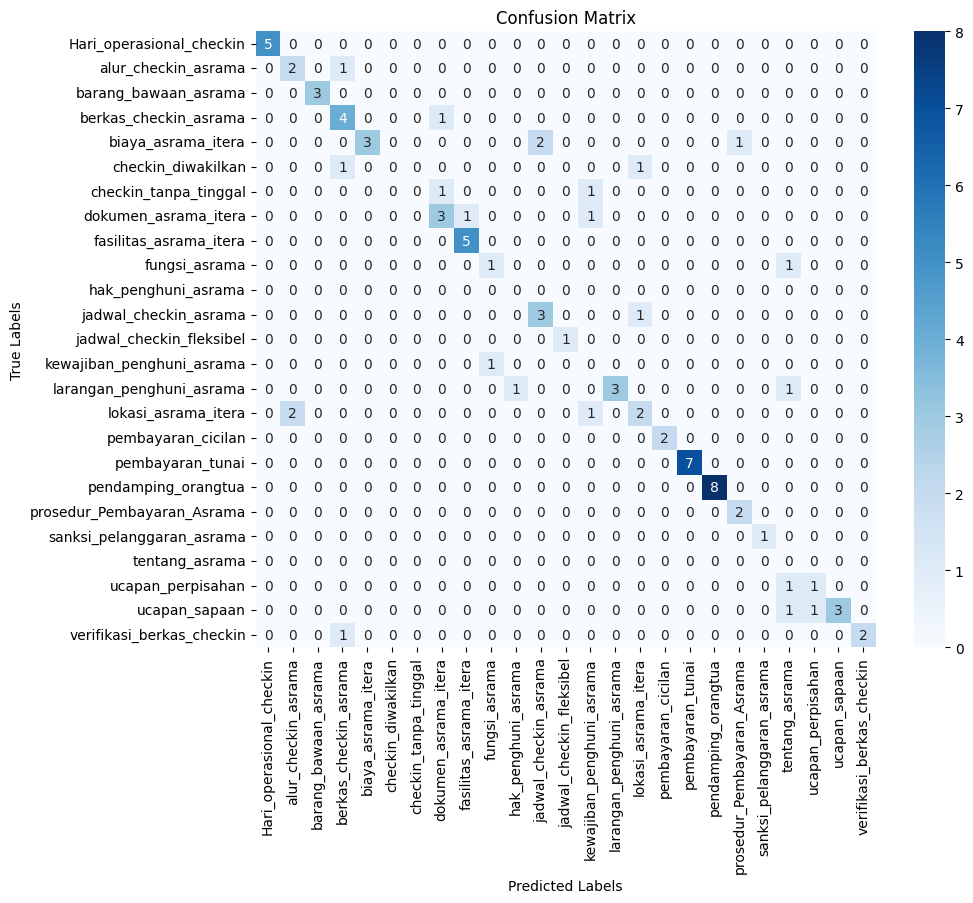

                            precision    recall  f1-score   support

  Hari_operasional_checkin       1.00      1.00      1.00         5
       alur_checkin_asrama       0.50      0.67      0.57         3
      barang_bawaan_asrama       1.00      1.00      1.00         3
     berkas_checkin_asrama       0.57      0.80      0.67         5
        biaya_asrama_itera       1.00      0.50      0.67         6
        checkin_diwakilkan       0.00      0.00      0.00         2
     checkin_tanpa_tinggal       0.00      0.00      0.00         2
      dokumen_asrama_itera       0.60      0.60      0.60         5
    fasilitas_asrama_itera       0.83      1.00      0.91         5
             fungsi_asrama       0.50      0.50      0.50         2
       hak_penghuni_asrama       0.00      0.00      0.00         0
     jadwal_checkin_asrama       0.60      0.75      0.67         4
  jadwal_checkin_fleksibel       1.00      1.00      1.00         1
 kewajiban_penghuni_asrama       0.00      0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
# membuat grafik confussin matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Akurasi: 0.73
Precision: 0.78
Recall: 0.73
F1-score: 0.74


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


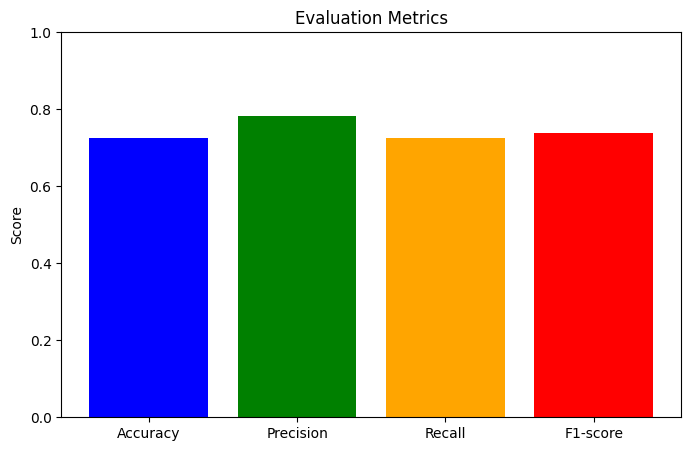

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung metrik
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Menampilkan metrik
print(f"Akurasi: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Bar plot untuk visualisasi metrik
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange', 'red'])
plt.title("Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()


In [ ]:
# prompt: buat kode untuk menghitung akurasi pada data latih dan data uji

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


# Evaluasi model pada data latih
y_pred_train = model.predict(x_train)
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
train_accuracy = accuracy_score(y_train, y_pred_train_classes)
print(f"Akurasi Data Latih: {train_accuracy:.4f}")

# Evaluasi model pada data uji (sudah ada di kode sebelumnya)
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Akurasi Data Uji: {accuracy:.4f}")




11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Akurasi Data Latih: 1.0000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7225 - loss: 3.7434 
Akurasi Data Uji: 0.7262


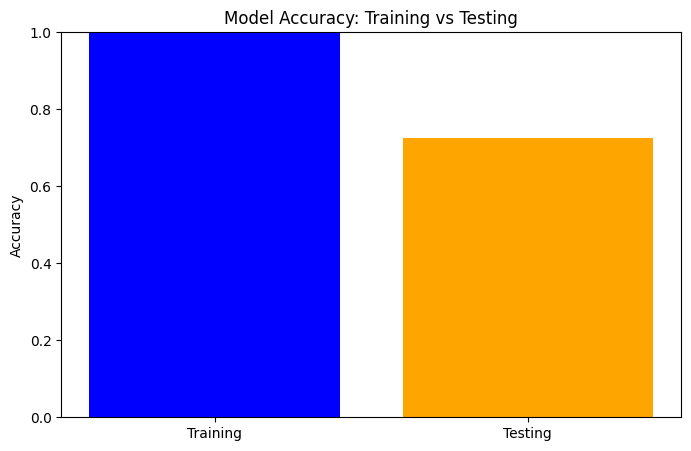

In [ ]:
# Data untuk visualisasi
datasets = ['Training', 'Testing']
accuracies = [train_accuracy, accuracy]

# Plot akurasi
plt.figure(figsize=(8, 5))
plt.bar(datasets, accuracies, color=['blue', 'orange'])
plt.title("Model Accuracy: Training vs Testing")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.show()


**Overfitting**:

- Jika akurasi data latih jauh lebih tinggi dibandingkan dengan akurasi data uji, model mengalami overfitting.

Ini menunjukkan model terlalu fokus pada data latih hingga gagal menggeneralisasi pada data baru.

**Underfitting**:

- Jika akurasi data latih dan uji sama-sama rendah, model mengalami underfitting.
Ini menunjukkan model gagal menangkap pola dalam data.

**Ideal**:

Akurasi data latih dan data uji seimbang, serta keduanya tinggi.

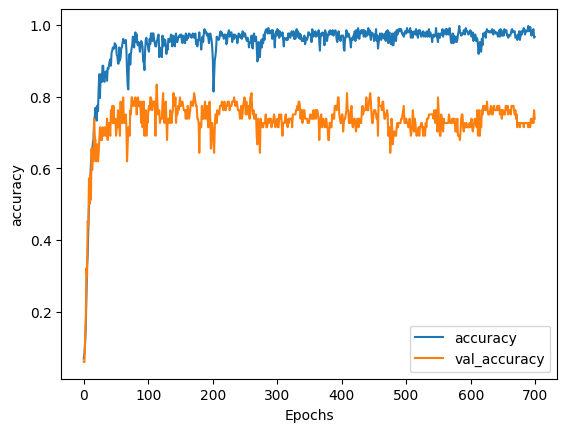

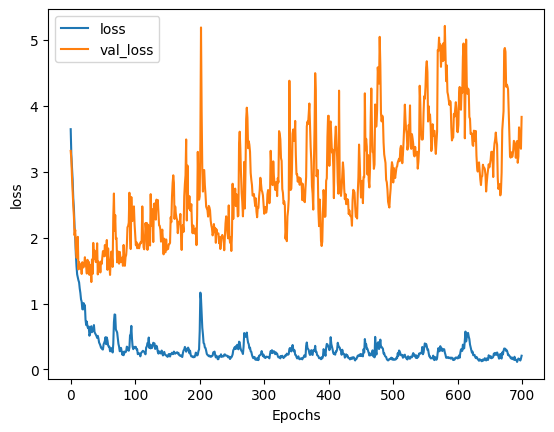

In [ ]:
#diisi dengan plot hasil accuray dan loss training dan testing


# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Testing Chatbot

In [ ]:
#LOAD MODEL
model = load_model('BILSTM_model.h5')

In [15]:
import string
import random
import numpy as np
from keras.preprocessing.sequence import pad_sequences

while True:
    texts_p = []
    print("Ketik 'keluar' untuk menyelesaikan program.")
    prediction_input = input('👨‍🦰 Kamu : ')

    # Menghapus punktuasi dan konversi ke huruf kecil
    processed_input = ''.join([letters.lower() for letters in prediction_input if letters not in string.punctuation])
    texts_p.append(processed_input)

    # Tokenisasi dan Padding
    try:


        prediction_input = tokenizer.texts_to_sequences(texts_p)
        prediction_input = np.array(prediction_input).reshape(-1)
        prediction_input = pad_sequences([prediction_input], maxlen=max_sequence_length)

        # Mendapatkan hasil keluaran dari model
        output = model.predict(prediction_input)
        confidence = np.max(output)  # Confidence level
        output_index = output.argmax()  # Index dari prediksi
        response_tag = le.inverse_transform([output_index])[0]  # Mendapatkan tag respon

        # Menampilkan response_tag, confidence, dan respon
        print(f"(Tag: {response_tag}, Confidence: {confidence:.2f})")
        print(f"🤖 ChatbotX:", random.choice(responses[response_tag]))
    except Exception as e:
        # Menangani input yang tidak sesuai atau error
        print("🤖 ChatbotX: Maaf, saya tidak mengerti. Coba masukkan input yang lebih jelas.")
        print(f"Debug Info: {e}")  # Untuk debugging jika terjadi error (opsional)

    # Check jika input asli adalah "keluar" sebelum diproses
    if response_tag == "ucapan_perpisahan":
        print("🤖 ChatbotX: Sampai jumpa!")
        break


Ketik 'keluar' untuk menyelesaikan program.
👨‍🦰 Kamu : halo
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(Tag: ucapan_sapaan, Confidence: 1.00)
🤖 ChatbotX: Hi ITERA Friends, kenalkan saya chatbot FAQ yang siap menjawab pertanyaan anda
Ketik 'keluar' untuk menyelesaikan program.
👨‍🦰 Kamu : apa fasilitas asrama itera
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(Tag: fasilitas_asrama_itera, Confidence: 0.50)
🤖 ChatbotX: Setiap kamar di asrama akan dihuni oleh 3-4 orang mahasiswa dengan fasilitas kasur, bantal, lemari, meja, kursi belajar, dan kamar mandi. Selain itu, listrik dan air gratis, serta ada lapangan bola dan taman hijau untuk rekreasi.
Ketik 'keluar' untuk menyelesaikan program.
👨‍🦰 Kamu : apa saja barang yang bisa dibawa ke asrama?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
(Tag: barang_bawaan_asrama, Confidence: 1.00)
🤖 ChatbotX: Mahasiswa dapat membawa barang pribadi ke asrama, tetapi hanya laptop dan handphone yang diizinkan sebagai alat elektronik. Dilarang membawa senjata tajam, kompor, dan b

KeyboardInterrupt: Interrupted by user

In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, GlobalMaxPool1D, Bidirectional, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D
from keras.callbacks import EarlyStopping, LearningRateScheduler
from collections import Counter
import re
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pickle

# Save necessary files for deployment

# 1. Save the trained model
#model.save('BILSTM_model.h5')

# 2. Save the tokenizer
#import pickle
#with open('tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 3. Save the label encoder
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 4. Save the max_sequence_length
with open('max_sequence_length.txt', 'w') as f:
    f.write(str(max_sequence_length))


# Create a requirements.txt file for deployment environment.
# This lists all the necessary packages along with specific versions
with open("requirements.txt", "w") as f:
    f.write("tensorflow==2.12.0\n") # Specify your tensorflow version
    f.write("nltk==3.8.1\n") # Specify your nltk version
    f.write("scikit-learn==1.2.2\n") # Or your preferred scikit-learn version
    f.write("pandas==1.5.3\n")
    f.write("numpy==1.23.5\n")
    f.write("matplotlib==3.7.1\n")
    f.write("seaborn==0.12.2\n")
    f.write("keras==2.12.0\n") # specify your keras version
    # Add other required packages with their versions
    # example:  f.write("google-cloud-storage==2.10.0\n")
    # Note down all the packages you import in your code

print("Model, tokenizer, label encoder, max_sequence_length, and requirements.txt saved successfully.")

Model, tokenizer, label encoder, max_sequence_length, and requirements.txt saved successfully.


In [ ]:
# prompt: buat kode untuk memuat ulang semua file

import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, GlobalMaxPool1D, Bidirectional, Conv1D, MaxPooling1D, Bidirectional, GRU, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, LearningRateScheduler
from collections import Counter
import re
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Reload necessary files (added at the beginning)
try:
    # 1. Load the trained model
    model = load_model('BILSTM_model.h5')

    # 2. Load the tokenizer
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # 3. Load the label encoder
    with open('label_encoder.pickle', 'rb') as handle:
        le = pickle.load(handle)

    # 4. Load the max_sequence_length
    with open('max_sequence_length.txt', 'r') as f:
        max_sequence_length = int(f.read())

    print("Model, tokenizer, label encoder, responses, and max_sequence_length loaded successfully.")

except FileNotFoundError:
    print("Error: One or more necessary files not found. Please run the previous code to save them.")
except Exception as e:
    print(f"An error occurred while loading files: {e}")


Model, tokenizer, label encoder, responses, and max_sequence_length loaded successfully.
